# Cardiovascular Disease Prediction Using Ensemble Technique

 This research intends to pinpoint the risk factors of heart disease as well as predict the overall risk using an ensemble of 3 best performing modedls out of the following:`[LOGISTIC REGRESSION,KNN, NB,SVM, Random Forest, Decision Tree, XGBoost, GradientBoosting, AdaBoost]`.




### About Dataset (Meta data)

#### Column Descriptions:

##### Data description

There are 3 types of input features:

- Objective: factual information;

- Examination: results of medical examination;

- Subjective: information given by the patient.


##### Features:

1. Age | Objective Feature | age | int (days)

2. Height | Objective Feature | height | int (cm) |

3. Weight | Objective Feature | weight | float (kg) |

4. Gender | Objective Feature | gender | categorical code | 2: male, 1: female

5. Systolic blood pressure | Examination Feature | ap_hi | int |

6. Diastolic blood pressure | Examination Feature | ap_lo | int |

7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

9. Smoking | Subjective Feature | smoke | binary |

10. Alcohol intake | Subjective Feature | alco | binary |

12. Physical activity | Subjective Feature | active | binary |

13. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


All of the dataset values were collected at the moment of medical examination.

# Import Libraries
lets start the project by importing all the libraries that we will need in the project.

In [3]:
# import libraries

# 1. to handle the data
import pandas as pd
import numpy as np

# 2. To Viusalize the data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.colors import ListedColormap

# 5. Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score

# 6. For Classification task.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier,RandomForestRegressor
# from xgboost import XGBClassifier

# 7. Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 8. Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Load the Dataset

In [4]:
df = pd.read_csv("cardio_train.csv", sep=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
df.shape

(70000, 13)

The data has 70,000 rows ans 13 columns

In [6]:
df.drop("id", axis=1, inplace=True) # drop the id column because it is of no use to us

# calculate the age from the days in the age column
df['age'] = (df['age'] / 365).round().astype(int)
df.drop_duplicates(inplace=True)

df.insert(4, 'bmi', round((df['weight']/(df['height']/100)**2), 2))

df.head()

,age,gender,height,weight,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,21.97,110,80,1,1,0,0,1,0
1,55,1,156,85.0,34.93,140,90,3,1,0,0,1,1
2,52,1,165,64.0,23.51,130,70,3,1,0,0,0,1
3,48,2,169,82.0,28.71,150,100,1,1,0,0,1,1
4,48,1,156,56.0,23.01,100,60,1,1,0,0,0,0


In [7]:
df['gender'] = df['gender'].map({1: 'Female', 2: 'Male'})
df['cholesterol'] = df['cholesterol'].map({1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'})
df['gluc'] = df['gluc'].map({1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'})
df['smoke'] = df['smoke'].map({0: 'No', 1: 'Yes'})
df['alco'] = df['alco'].map({0: 'No', 1: 'Yes'})
df['active'] = df['active'].map({0: 'No', 1: 'Yes'})

Normal resting blood pressure in an adult is approximately 120 millimetres of mercury (16 kPa) systolic (ap_hi) over 80 millimetres of mercury (11 kPa) diastolic (ap_lo), denoted as "120/80 mmHg"

We are goinf to filter out data points that have ap_hi and ap_lo values that falls too high or too low from the normal

In [8]:
out_filter = ((df["ap_hi"] > 175) | (df["ap_lo"] > 120))
df = df[~out_filter]

out_filter2 = ((df["ap_hi"] < 75) | (df["ap_lo"] < 50))
df = df[~out_filter2]

In [9]:
df.shape # new shape: we filtered over 6,000 rows of data

(63961, 13)

Mean arterial pressure is an average calculated blood pressure in an individual during a single cardiac cycle. Although methods of estimating MAP vary, a common calculation is to take one-third of the pulse pressure, and add that amount to the diastolic pressure. A normal MAP is about 90 mmHg.

In [10]:
# Create 'MAP' (Mean Arterial Pressure)
df['map'] = ((2 * df['ap_lo']) + df['ap_hi']) / 3

In [11]:
df.gender.value_counts()

gender
Female    41208
Male      22753
Name: count, dtype: int64

In [12]:
df_male = df[df['gender'] == 'Male']
df_female = df[df['gender'] == 'Female']

male_count = len(df_male)
print(f"\nMale count (minority class): {male_count}")

df_female_downsampled = df_female.sample(n=male_count, random_state=42) # random_state for reproducibility

# Concatenate the downsampled majority class with the minority class
df_balanced = pd.concat([df_male, df_female_downsampled])

# Shuffle the balanced DataFrame to mix the samples
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


Male count (minority class): 22753


In [13]:
df.gender.value_counts()

gender
Female    22753
Male      22753
Name: count, dtype: int64

In [14]:
df.describe()

,age,height,weight,bmi,ap_hi,ap_lo,cardio,map
count,45506.000000,45506.000000,45506.000000,45506.000000,45506.000000,45506.000000,45506.000000,45506.000000
mean,53.285501,165.631895,75.017054,27.419027,126.490836,81.338812,0.504791,96.389487
std,6.845367,8.436005,14.433359,5.956512,15.517729,9.246175,0.499983,10.489643
min,30.000000,55.000000,11.000000,3.470000,80.000000,50.000000,0.000000,60.000000
25%,48.000000,160.000000,65.000000,23.880000,120.000000,80.000000,0.000000,93.333333
50%,54.000000,166.000000,73.000000,26.370000,120.000000,80.000000,1.000000,93.333333
75%,58.000000,171.000000,83.000000,30.060000,140.000000,90.000000,1.000000,103.333333
max,65.000000,250.000000,200.000000,298.670000,175.000000,120.000000,1.000000,137.666667


# Exploratory Data Analysis (EDA)
### Explore Each Column

In [15]:
# Exploring the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45506 entries, 0 to 45505
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          45506 non-null  int64  
 1   gender       45506 non-null  object 
 2   height       45506 non-null  int64  
 3   weight       45506 non-null  float64
 4   bmi          45506 non-null  float64
 5   ap_hi        45506 non-null  int64  
 6   ap_lo        45506 non-null  int64  
 7   cholesterol  45506 non-null  object 
 8   gluc         45506 non-null  object 
 9   smoke        45506 non-null  object 
 10  alco         45506 non-null  object 
 11  active       45506 non-null  object 
 12  cardio       45506 non-null  int64  
 13  map          45506 non-null  float64
dtypes: float64(3), int64(5), object(6)
memory usage: 4.9+ MB


In [16]:
# age column age range
df['age'].min(), df['age'].max()

(30, 65)

## Visualizations

In [17]:
# lets summerize the age column
df['age'].describe()

count    45506.000000
mean        53.285501
std          6.845367
min         30.000000
25%         48.000000
50%         54.000000
75%         58.000000
max         65.000000
Name: age, dtype: float64

from the result above, it looks lik our age column is going to have a left skewed distribution, seeing the mean, std and the min

<Axes: xlabel='age', ylabel='Count'>

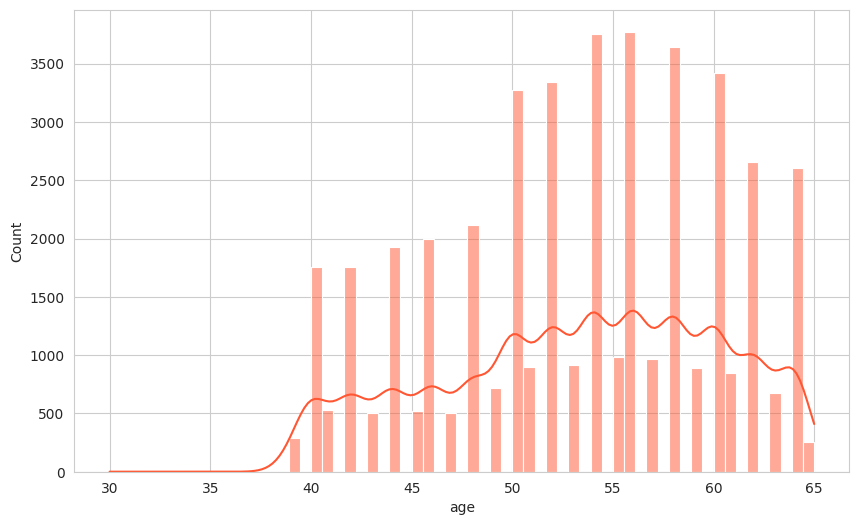

In [ ]:
import seaborn as sns

# Define custom colors
custom_colors = ["#FF5733", "#3366FF", "#33FF57"]  # Example colors, you can adjust as needed

# Plot the histogram with custom colors
sns.histplot(df['age'], kde=True, color="#FF5733", palette=custom_colors)


Mean 53.285500813079594
Median 54.0
Mode 0    56
Name: age, dtype: int64


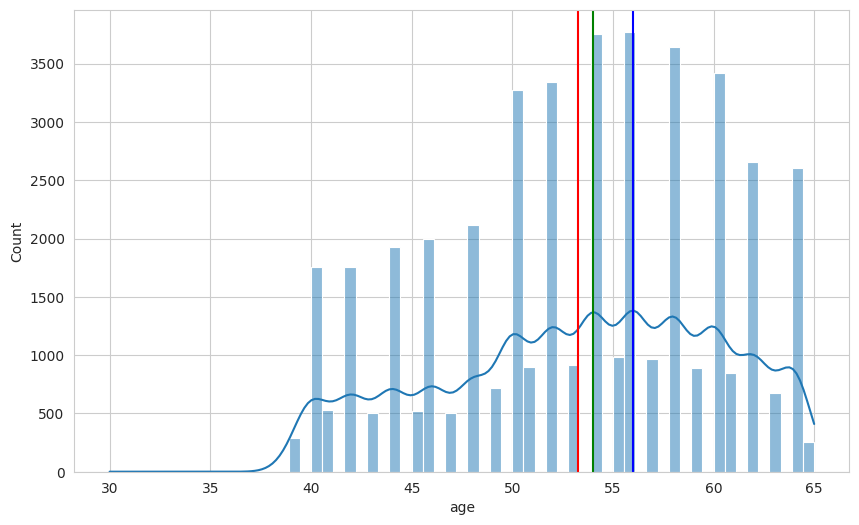

In [ ]:
# Plot the mean, Median and mode of age column using sns
sns.histplot(df['age'], kde=True)
plt.axvline(df['age'].mean(), color='Red')
plt.axvline(df['age'].median(), color= 'Green')
plt.axvline(df['age'].mode()[0], color='Blue')

# print the value of mean, median and mode of age column
print('Mean', df['age'].mean())
print('Median', df['age'].median())
print('Mode', df['age'].mode())


we see here that the median is greater than the mean, this further confirms my hypothesis that the distribution is left-skewed

Lets explore the gender base distribution of the dataset for age column

In [ ]:
# plot the histogram of age column using plotly and coloring this by sex

fig = px.histogram(data_frame=df, x='age', color= 'gender')
fig.show()

In [ ]:
# Find the values of sex column
df['gender'].value_counts()

,count
gender,
Female,22753
Male,22753


we have more females than males

In [ ]:
# calculating the percentage fo male and female value counts in the data

male_count = df['gender'].value_counts()['Male']
female_count = df['gender'].value_counts()['Female']

total_count = male_count + female_count

# calculate percentages
male_percentage = (male_count/total_count)*100
female_percentages = (female_count/total_count)*100

# display the results
print(f'Male percentage i the data: {male_percentage:.2f}%')
print(f'Female percentage in the data : {female_percentages:.2f}%')


Male percentage i the data: 50.00%
Female percentage in the data : 50.00%


#### Exploring the dataset column

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

colors = sns.color_palette("viridis", 5)
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

### Univariate Analysis

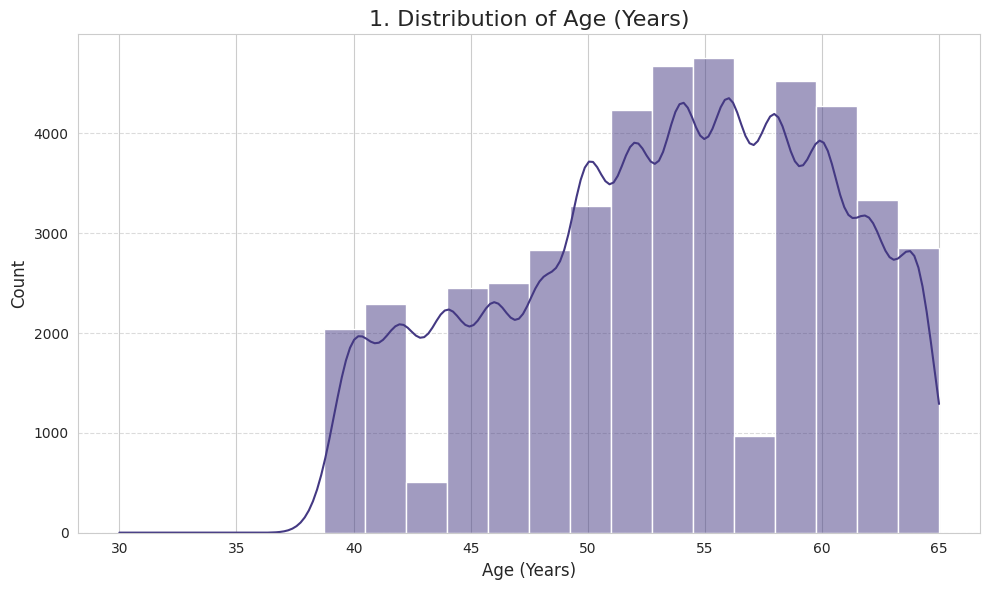

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True, bins=20, color=colors[0])
plt.title('1. Distribution of Age (Years)', fontsize=16)
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

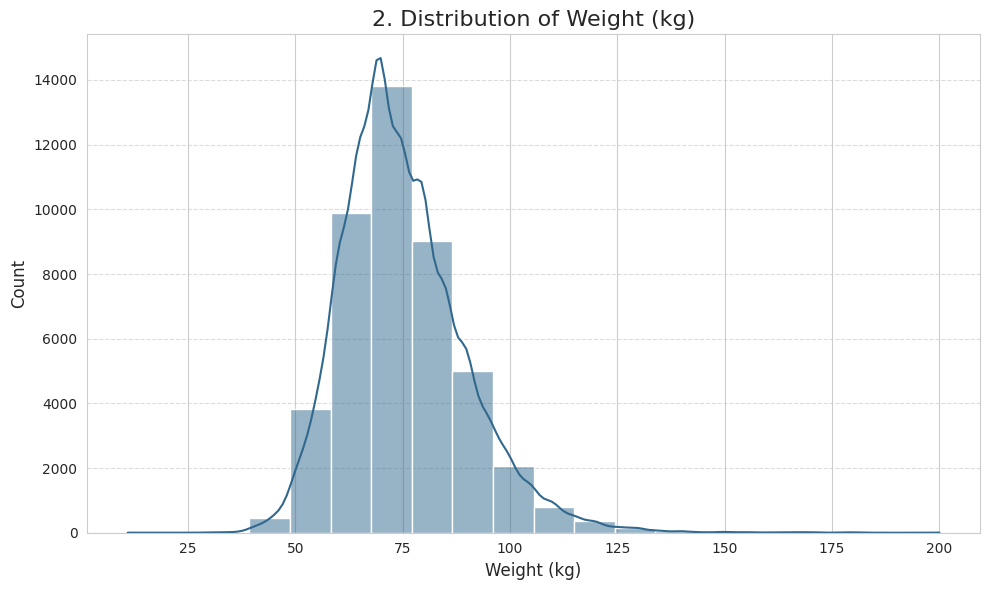

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['weight'], kde=True, bins=20, color=colors[1])
plt.title('2. Distribution of Weight (kg)', fontsize=16)
plt.xlabel('Weight (kg)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The weight is normaly distributed as seen in the bell curve

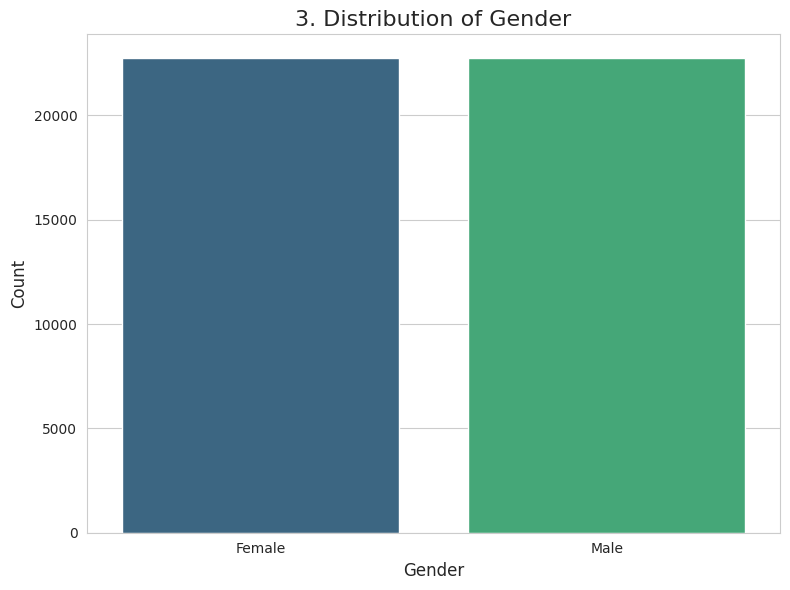

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df, palette='viridis')
plt.title('3. Distribution of Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

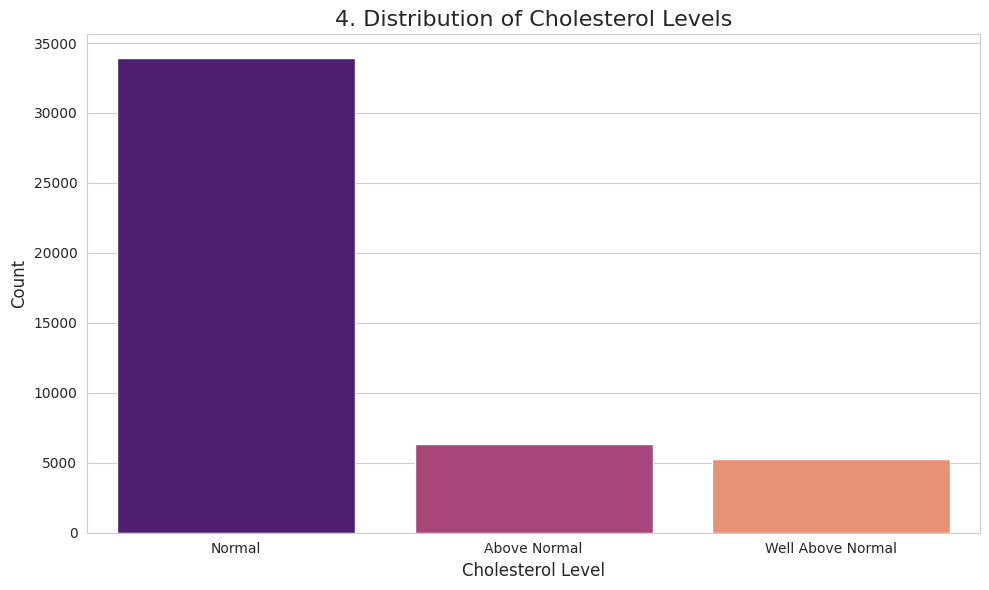

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cholesterol', data=df, palette='magma', order=['Normal', 'Above Normal', 'Well Above Normal'])
plt.title('4. Distribution of Cholesterol Levels', fontsize=16)
plt.xlabel('Cholesterol Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

### Bivariate Analysis

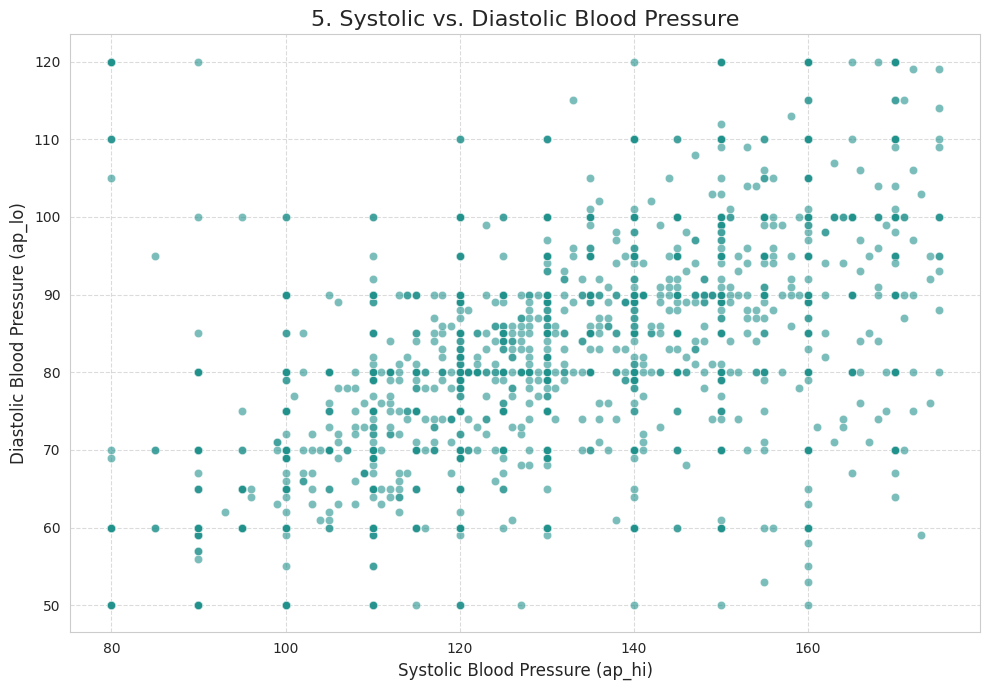

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='ap_hi', y='ap_lo', data=df, alpha=0.6, color=colors[2])
plt.title('5. Systolic vs. Diastolic Blood Pressure', fontsize=16)
plt.xlabel('Systolic Blood Pressure (ap_hi)', fontsize=12)
plt.ylabel('Diastolic Blood Pressure (ap_lo)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

we see a positive correlation between the Systolic and Diastolic Blood Pressure, a very useful feature for modeling

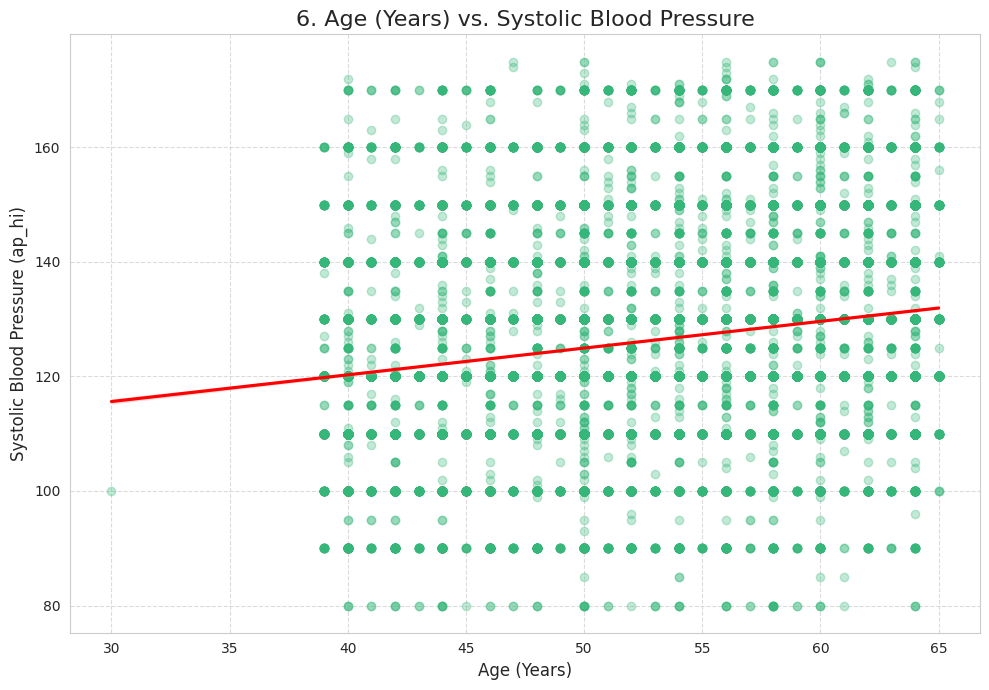

In [ ]:
plt.figure(figsize=(10, 7))
sns.regplot(x='age', y='ap_hi', data=df, scatter_kws={'alpha':0.3, 'color':colors[3]}, line_kws={'color':'red'})
plt.title('6. Age (Years) vs. Systolic Blood Pressure', fontsize=16)
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Systolic Blood Pressure (ap_hi)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This shows that patients advance in age, their Systolic Blood Pressure increases

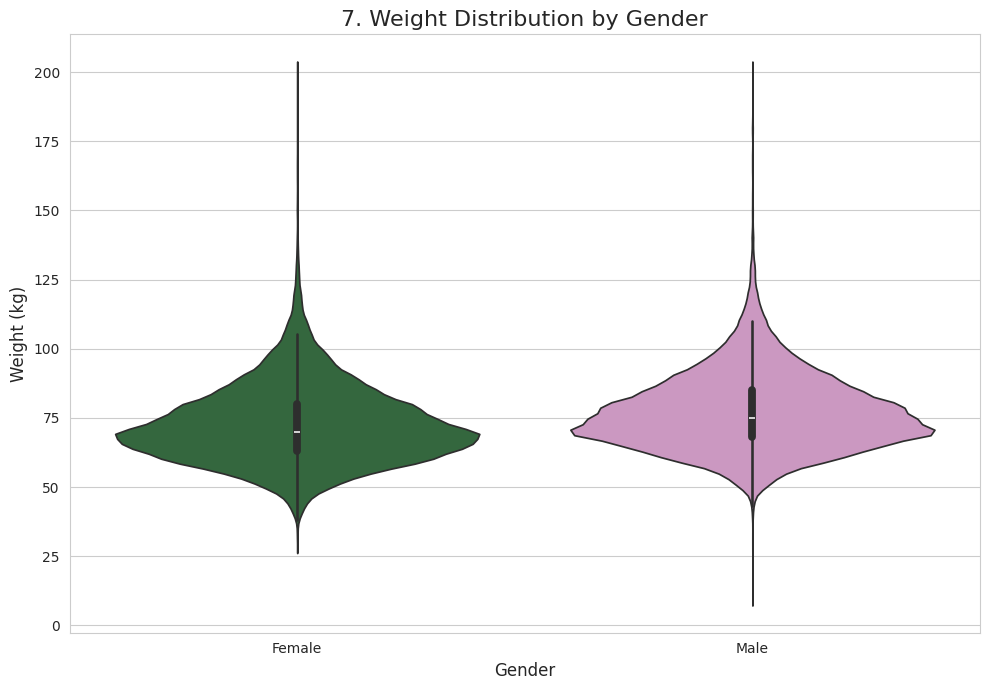

In [ ]:
plt.figure(figsize=(10, 7))
sns.violinplot(x='gender', y='weight', data=df, palette='cubehelix')
plt.title('7. Weight Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Weight (kg)', fontsize=12)
plt.tight_layout()
plt.show()

Basically same

In [ ]:
fig = px.bar(df.groupby(['cholesterol', 'gluc']).size().reset_index(name='count'),
             x='cholesterol',
             y='count',
             color='gluc',
             barmode='group',
             category_orders={"cholesterol": ['Normal', 'Above Normal', 'Well Above Normal'],
                              "gluc": ['Normal', 'Above Normal', 'Well Above Normal']},
             title='8. Cholesterol vs. Glucose Levels',
             labels={'cholesterol':'Cholesterol Level', 'count':'Count', 'gluc':'Glucose Level'})
fig.update_layout(title_font_size=16, xaxis_title_font_size=12, yaxis_title_font_size=12)
fig.show()

The majority of individuals in the dataset have Normal Cholesterol and Normal Glucose levels, with a count of 43,688. This suggests that a large portion of your sample is in a healthy range for these two indicators.

Among those with Above Normal Cholesterol, the most common glucose level is also Normal (6,384 individuals), followed by Above Normal (2,300 individuals), and then Well Above Normal (364 individuals).

For individuals with Well Above Normal Cholesterol, the most frequent glucose level is also Normal (3,891 individuals), indicating that high cholesterol doesn't always correlate with high glucose, although there's a significant number with Well Above Normal Glucose (3,272 individuals) in this group.

Similarly, for those with Normal Cholesterol, a considerable number still have Above Normal Glucose (2,152 individuals), and a smaller but notable group has Well Above Normal Glucose (1,438 individuals).

Multivariate Analysis

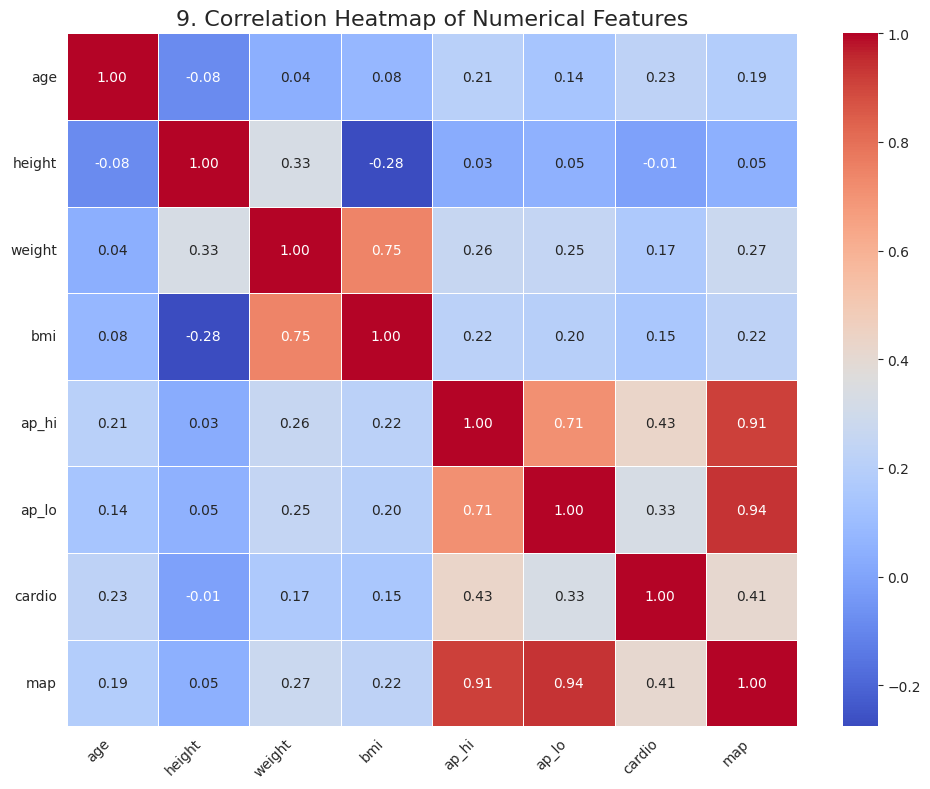

In [ ]:
plt.figure(figsize=(10, 8))
# Select numerical columns for correlation
correlation_matrix = df[df.select_dtypes(include='number').columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('9. Correlation Heatmap of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Most notably, there's a very strong positive correlation between systolic blood pressure (ap_hi) and diastolic blood pressure (ap_lo) (0.715), as well as an even stronger one between these and MAP (Mean Arterial Pressure) (0.912 for ap_hi and 0.939 for ap_lo), which is expected as MAP is derived from systolic and diastolic pressures. Weight and BMI also show a strong positive correlation (0.759), indicating that as weight increases, so does BMI, which is also a direct relationship. We observe moderate positive correlations between age and blood pressure metrics (e.g., 0.214 with ap_hi, 0.153 with ap_lo), suggesting that blood pressure tends to increase with age. Cardio (which likely represents a cardiovascular disease outcome) has moderate positive correlations with age (0.235), weight (0.169), and especially with blood pressure measurements (0.433 with ap_hi and 0.338 with ap_lo), implying that these factors contribute to cardiovascular risk. Interestingly, height shows a slight negative correlation with age (-0.083) and BMI (-0.289), and a weak positive correlation with weight (0.296), which might reflect the general trend of decreasing height with age or the calculation of BMI where height is in the denominator. Overall, the matrix highlights the interconnectedness of blood pressure metrics and the influence of age, weight, and BMI on cardiovascular health indicators.

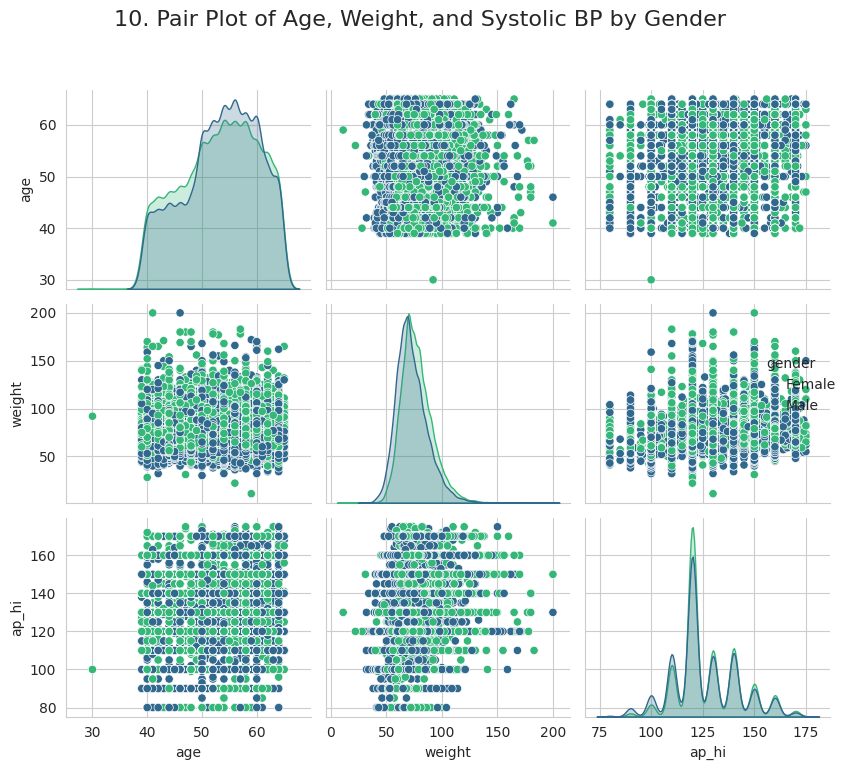

In [ ]:
selected_numerical_for_pairplot = ['age', 'weight', 'ap_hi']
sns.pairplot(df, vars=selected_numerical_for_pairplot, hue='gender', palette='viridis', diag_kind='kde')
plt.suptitle('10. Pair Plot of Age, Weight, and Systolic BP by Gender', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

With all we have seen, `ap_hi, ap_lo, age,` and `bmi` are the most impactful features, given their notable correlations with the cardio variable and other key health indicators.

map is highly correlated with both systolic and diastolic pressures, to avoid multicollinearity issues in the ensemble model, I will have to take it out

In [18]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
bmi            0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
map            0
dtype: int64

In [19]:
df['gender'] = df['gender'].map({'Female': 1, 'Male': 2})
df['cholesterol'] = df['cholesterol'].map({'Normal': 1, 'Above Normal': 2, 'Well Above Normal': 3})
df['gluc'] = df['gluc'].map({'Normal':1, 'Above Normal':2, 'Well Above Normal':3})
df['smoke'] = df['smoke'].map({'No':0, 'Yes':2})
df['alco'] = df['alco'].map({'No':0, 'Yes':1})
df['active'] = df['active'].map({'No':0, 'Yes':1})

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45506 entries, 0 to 45505
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          45506 non-null  int64  
 1   gender       45506 non-null  int64  
 2   height       45506 non-null  int64  
 3   weight       45506 non-null  float64
 4   bmi          45506 non-null  float64
 5   ap_hi        45506 non-null  int64  
 6   ap_lo        45506 non-null  int64  
 7   cholesterol  45506 non-null  int64  
 8   gluc         45506 non-null  int64  
 9   smoke        45506 non-null  int64  
 10  alco         45506 non-null  int64  
 11  active       45506 non-null  int64  
 12  cardio       45506 non-null  int64  
 13  map          45506 non-null  float64
dtypes: float64(3), int64(11)
memory usage: 4.9 MB


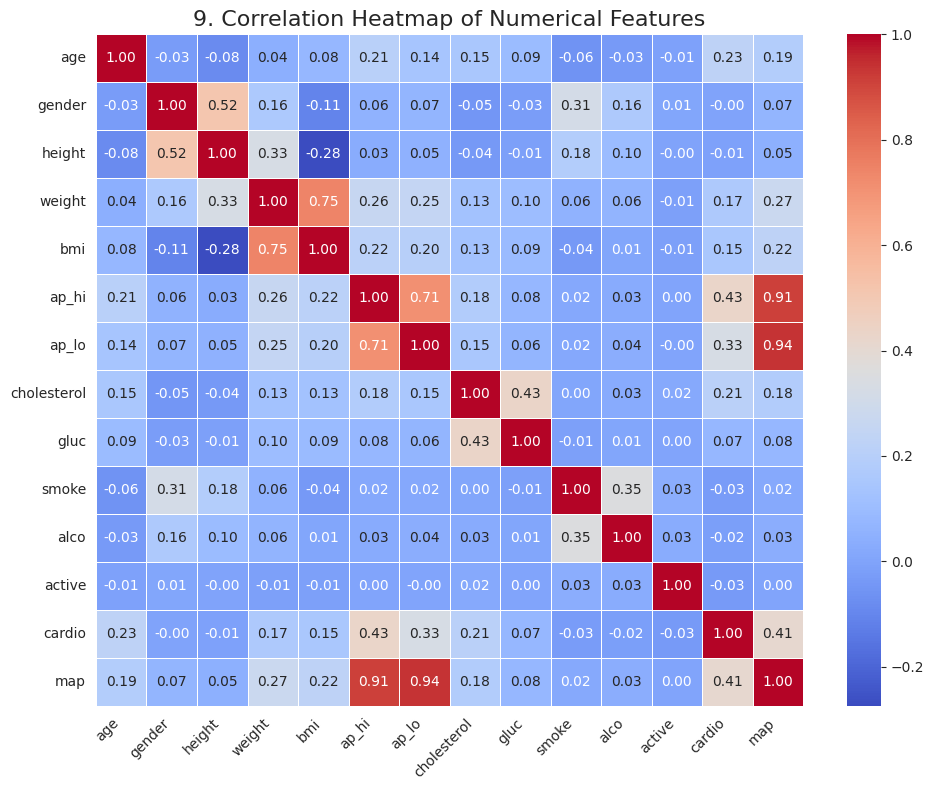

In [ ]:
plt.figure(figsize=(10, 8))
# Select numerical columns for correlation
correlation_matrix = df[df.select_dtypes(include='number').columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('9. Correlation Heatmap of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# `Machine Learning Models`

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45506 entries, 0 to 45505
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          45506 non-null  int64  
 1   gender       45506 non-null  int64  
 2   height       45506 non-null  int64  
 3   weight       45506 non-null  float64
 4   bmi          45506 non-null  float64
 5   ap_hi        45506 non-null  int64  
 6   ap_lo        45506 non-null  int64  
 7   cholesterol  45506 non-null  int64  
 8   gluc         45506 non-null  int64  
 9   smoke        45506 non-null  int64  
 10  alco         45506 non-null  int64  
 11  active       45506 non-null  int64  
 12  cardio       45506 non-null  int64  
 13  map          45506 non-null  float64
dtypes: float64(3), int64(11)
memory usage: 4.9 MB


In [22]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'map'],
      dtype='object')

In [23]:
df.head()

,age,gender,height,weight,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,map
0,50,1,160,107.0,41.80,130,80,1,1,0,0,1,1,96.666667
1,60,1,167,87.0,31.20,100,60,2,2,0,0,1,1,73.333333
2,59,2,169,70.0,24.51,150,80,3,1,0,0,1,1,103.333333
3,64,1,164,69.0,25.65,110,70,1,1,0,0,1,1,83.333333
4,46,2,173,72.0,24.06,140,80,3,3,0,0,0,0,100.000000


In [24]:
# split the data into X and y
X= df.drop(['cardio', 'alco', 'active', 'smoke', 'map',], axis=1)
y = df['cardio']

X.columns

Index(['age', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc'],
      dtype='object')

In [23]:
# from sklearn.preprocessing import StandardScaler

# # Columns to scale
# columns_to_scale = ['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo']

# # Initialize StandardScaler
# scaler = StandardScaler()

# # Scale the selected columns in the training and testing data
# X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [25]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

Feature Importances (Random Forest):
bmi            0.190041
age            0.148866
weight         0.141682
height         0.136186
ap_hi          0.117059
map            0.090400
ap_lo          0.056596
cholesterol    0.038691
gender         0.021252
gluc           0.019428
active         0.019203
smoke          0.011449
alco           0.009147
dtype: float64


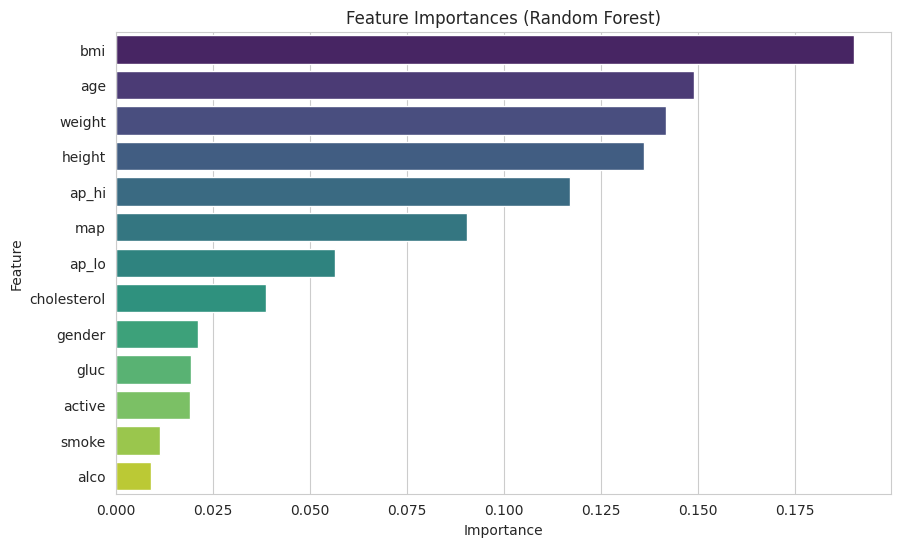

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Assuming X and y are already defined and preprocessed
# # Train a Random Forest Classifier
# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train)

# # Get feature importances
# feature_importances = model.feature_importances_

# # Create a pandas Series for better visualization
# feature_importances_series = pd.Series(feature_importances, index=X_train.columns)

# # Sort the features by importance
# sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# # Print the feature importances
# print("Feature Importances (Random Forest):")
# print(sorted_feature_importances)

# # Optionally, visualize the feature importances
# plt.figure(figsize=(10, 6))
# sns.barplot(x=sorted_feature_importances.values, y=sorted_feature_importances.index, palette='viridis')
# plt.title('Feature Importances (Random Forest)')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()

Enlist all the models that you will use to predict the heart disease. These models should be classifiers for multi_class classification.

1. logistic regression.
2. KNN
3. NB
4. SVM
5. Decision Tree
6. Random Forest
7. XGBoost
8. GradientBoosting
9. AdaBoost
10. lightGBM

In [27]:
# improt ALl models.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

#importing pipeline
from sklearn.pipeline import Pipeline

# import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error




`Create a function for models and evaluate them`

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
# !pip install catboost


In [28]:
# from catboost import CatBoostClassifier

In [29]:
# create a list of models to evaluate

models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('KNeighbors Classifier', KNeighborsClassifier()),
    ('Decision Tree Classifier', DecisionTreeClassifier(random_state=42)),
    ('AdaBoost Classifier', AdaBoostClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    # ('XGboost Classifier', XGBClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    # ('CatBoost Classifier', CatBoostClassifier(random_state=42)),

]

best_model = None
best_accuracy = 0.0

#Iterate over the models and evaluate their performance
for name, model in models:
    #create a pipeline for each model
    pipeline = Pipeline([
        ('model', model)
    ])

    # perform cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)

    # Calculate mean accuracy
    mean_accuracy = scores.mean()

    #fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # make prediction on the test data
    y_pred = pipeline.predict(X_test)

    #Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    #print the performance metrics
    print("Model", name)
    print("Cross Validatino accuracy: ", mean_accuracy)
    print("Test Accuracy: ", accuracy)
    print()

    #Check if the current model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

# Retrieve the best model
print("Best Model: ", best_model)





Model Logistic Regression
Cross Validatino accuracy:  0.7191793370069018
Test Accuracy:  0.7185234014502307

Model Gradient Boosting
Cross Validatino accuracy:  0.725222595012459
Test Accuracy:  0.7219292463194902

Model KNeighbors Classifier
Cross Validatino accuracy:  0.6777550858700426
Test Accuracy:  0.6660074708855197

Model Decision Tree Classifier
Cross Validatino accuracy:  0.6162235933960284
Test Accuracy:  0.6170072511535926

Model AdaBoost Classifier
Cross Validatino accuracy:  0.7210197058126602
Test Accuracy:  0.7199516589760492

Model Random Forest
Cross Validatino accuracy:  0.691847002057138
Test Accuracy:  0.6803999121072292

Model Support Vector Machine
Cross Validatino accuracy:  0.7146467963433352
Test Accuracy:  0.7157767523621182

Best Model:  Pipeline(steps=[('model', GradientBoostingClassifier(random_state=42))])


Model: Logistic Regression
Cross-Validation Accuracy: 0.7192
Test Accuracy: 0.7185

Confusion Matrix:


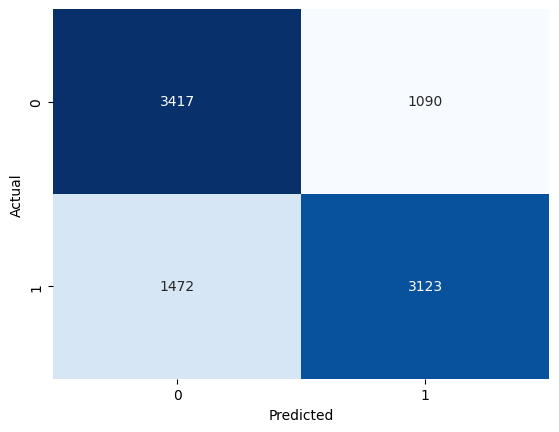


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      4507
           1       0.74      0.68      0.71      4595

    accuracy                           0.72      9102
   macro avg       0.72      0.72      0.72      9102
weighted avg       0.72      0.72      0.72      9102

--------------------------------------------------


Model: Gradient Boosting
Cross-Validation Accuracy: 0.7252
Test Accuracy: 0.7219

Confusion Matrix:


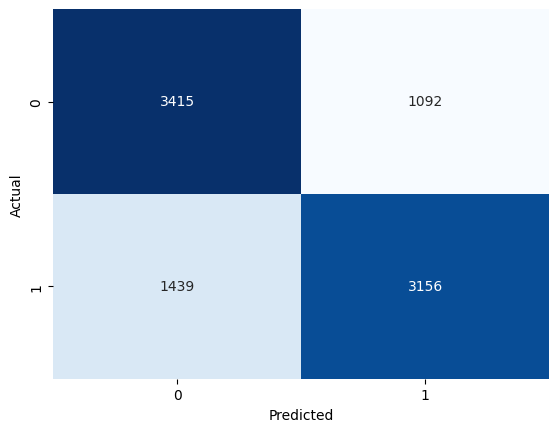


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      4507
           1       0.74      0.69      0.71      4595

    accuracy                           0.72      9102
   macro avg       0.72      0.72      0.72      9102
weighted avg       0.72      0.72      0.72      9102

--------------------------------------------------


Model: KNeighbors Classifier
Cross-Validation Accuracy: 0.6778
Test Accuracy: 0.6660

Confusion Matrix:


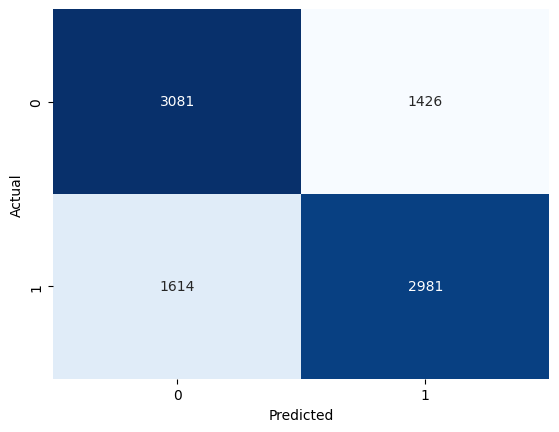


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      4507
           1       0.68      0.65      0.66      4595

    accuracy                           0.67      9102
   macro avg       0.67      0.67      0.67      9102
weighted avg       0.67      0.67      0.67      9102

--------------------------------------------------


Model: Decision Tree Classifier
Cross-Validation Accuracy: 0.6162
Test Accuracy: 0.6170

Confusion Matrix:


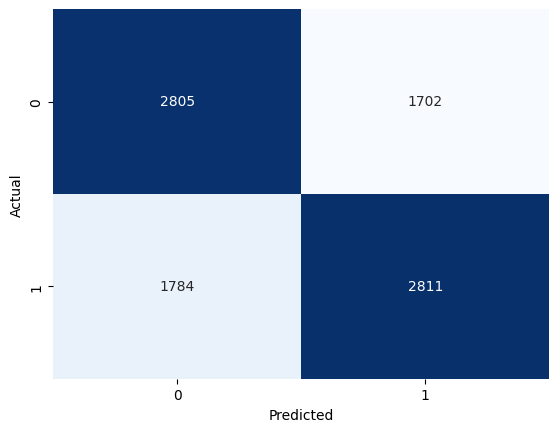


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      4507
           1       0.62      0.61      0.62      4595

    accuracy                           0.62      9102
   macro avg       0.62      0.62      0.62      9102
weighted avg       0.62      0.62      0.62      9102

--------------------------------------------------


Model: AdaBoost Classifier
Cross-Validation Accuracy: 0.7210
Test Accuracy: 0.7200

Confusion Matrix:


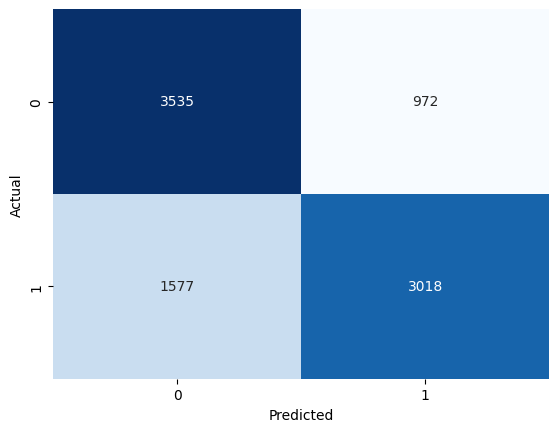


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.74      4507
           1       0.76      0.66      0.70      4595

    accuracy                           0.72      9102
   macro avg       0.72      0.72      0.72      9102
weighted avg       0.72      0.72      0.72      9102

--------------------------------------------------


Model: Random Forest
Cross-Validation Accuracy: 0.6918
Test Accuracy: 0.6804

Confusion Matrix:


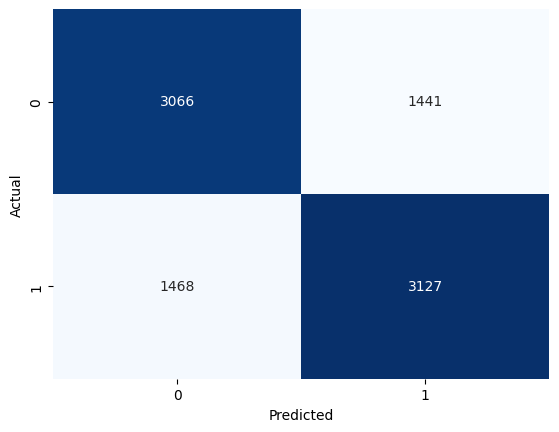


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4507
           1       0.68      0.68      0.68      4595

    accuracy                           0.68      9102
   macro avg       0.68      0.68      0.68      9102
weighted avg       0.68      0.68      0.68      9102

--------------------------------------------------


Model: Support Vector Machine
Cross-Validation Accuracy: 0.7146
Test Accuracy: 0.7158

Confusion Matrix:


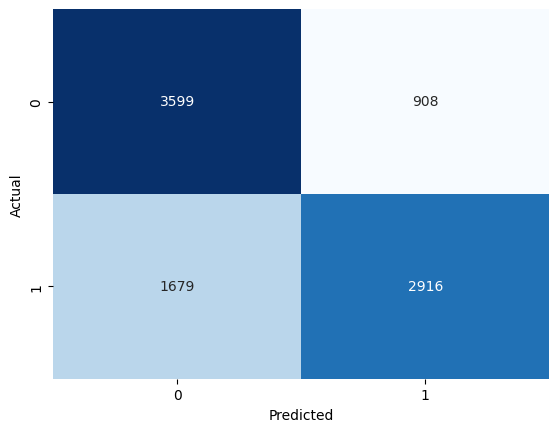


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.80      0.74      4507
           1       0.76      0.63      0.69      4595

    accuracy                           0.72      9102
   macro avg       0.72      0.72      0.71      9102
weighted avg       0.72      0.72      0.71      9102

--------------------------------------------------


Best Model:
Pipeline(steps=[('model', GradientBoostingClassifier(random_state=42))])


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

# Iterate over the models and evaluate their performance
for name, model in models:
    # Create a pipeline for each model
    pipeline = Pipeline([
        ('model', model)
    ])

    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)

    # Calculate mean accuracy
    mean_accuracy = scores.mean()

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Print the performance metrics
    print(f"Model: {name}")
    print(f"Cross-Validation Accuracy: {mean_accuracy:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(cr)
    print("-" * 50)
    print("\n")

    # Check if the current model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

# Retrieve the best model
print("Best Model:")
print(best_model)


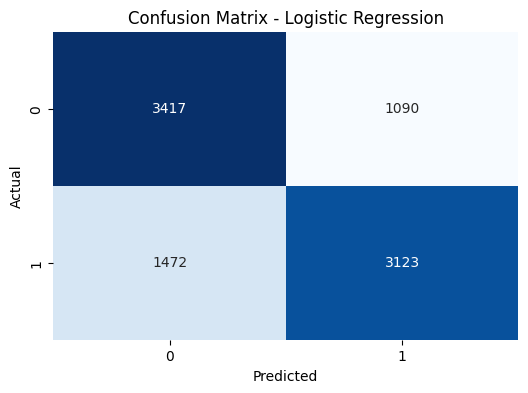

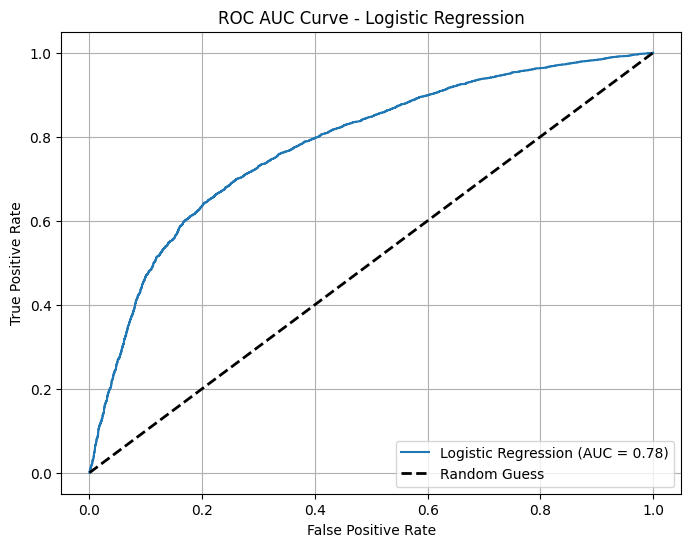

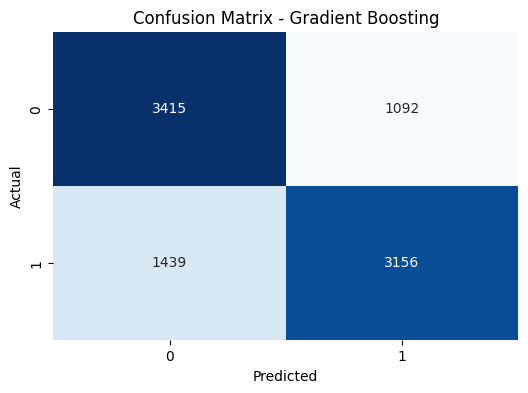

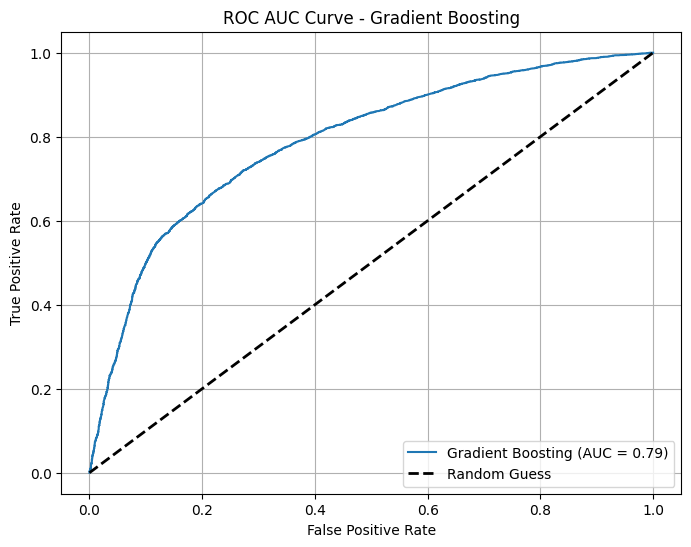

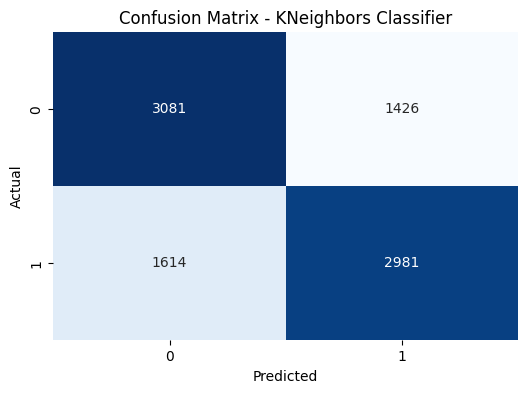

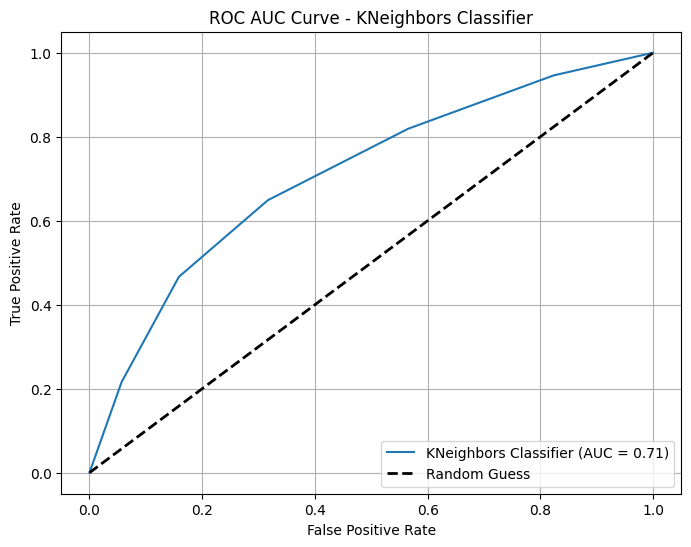

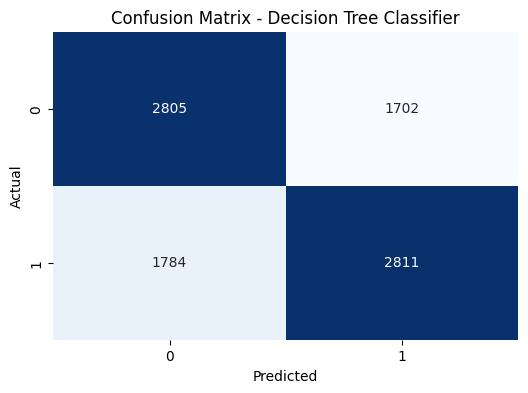

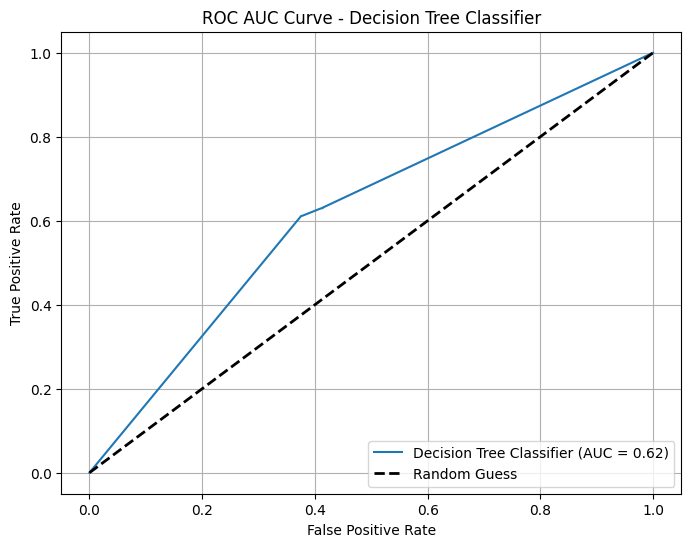

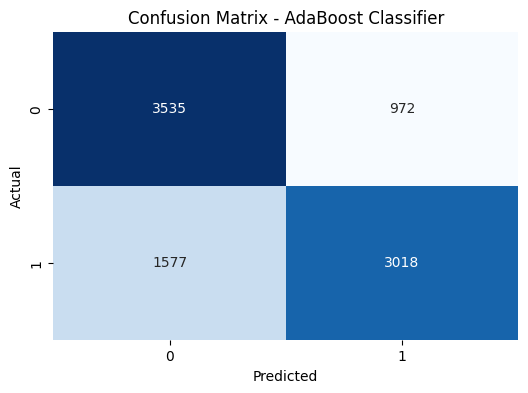

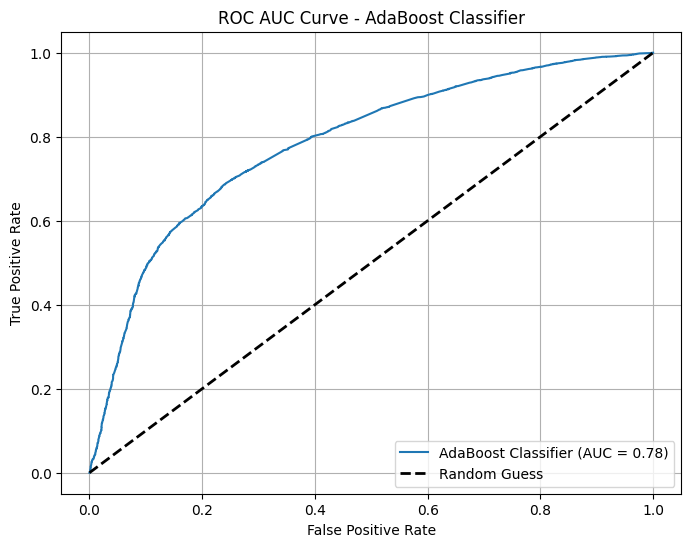

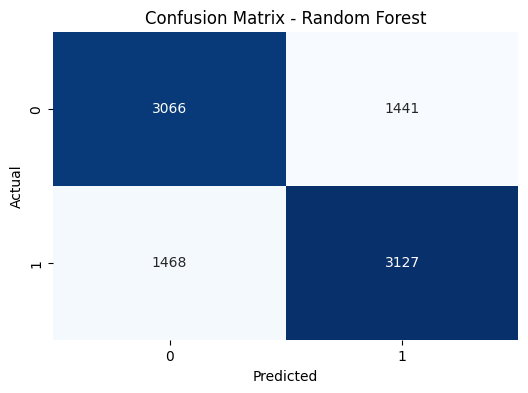

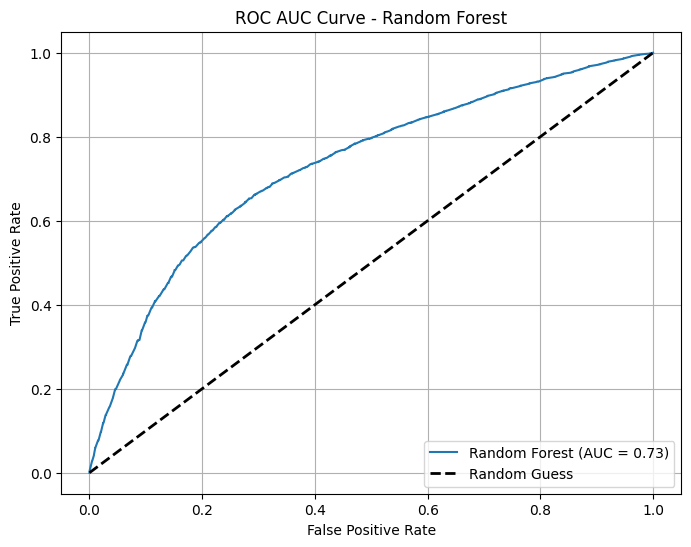

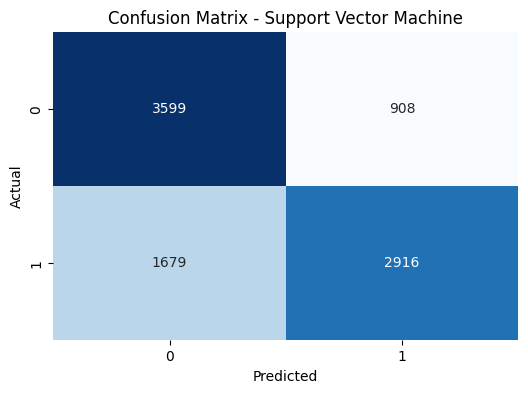

Support Vector Machine does not support probability predictions. Skipping ROC AUC Curve.


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Iterate over the models and evaluate their performance
for name, model in models:
    # Create a pipeline for each model
    pipeline = Pipeline([
        ('model', model)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC AUC Curve
    if y_proba is not None:  # Only plot ROC curve if the model supports probability prediction
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")
        plt.title(f"ROC AUC Curve - {name}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()
    else:
        print(f"{name} does not support probability predictions. Skipping ROC AUC Curve.")


In [32]:
import joblib

name, model = best_model.steps[0]

In [33]:
filename = f'GBC_{name}.joblib'

with open(filename, 'wb') as file:
    joblib.dump(model, file)


In [3]:
import pickle

# Define the filename
filename = '/content/drive/MyDrive/Jobs/Heart Disease Prediction/GBC_model.pkl'

# Load the model from the file
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

# You can now use the loaded_model for predictions
print("Model loaded successfully!")

Model loaded successfully!


In [4]:
loaded_model.predict(np.array([[45, 1, 143, 100.4, 39.34, 135, 85, 2, 2]]))

array([1])

In [34]:
joblib.__version__

'1.4.2'

In [ ]:
X.head()

,age,gender,height,weight,bmi,ap_hi,ap_lo,cholesterol,gluc
0,50,1,160,107.0,41.80,130,80,1,1
1,60,1,167,87.0,31.20,100,60,2,2
2,59,2,169,70.0,24.51,150,80,3,1
3,64,1,164,69.0,25.65,110,70,1,1
4,46,2,173,72.0,24.06,140,80,3,3


In [ ]:
import sklearn
print(np.__version__)

2.0.2


In [ ]:
print(pickle.format_version)

4.0
